In [12]:
from math import ceil

from os.path import join
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## How to use this notebook

**Input**: Contig summary statistics table(s) `ctg_stats.csv` generated by the rule `concat_statistics` and contig length table(s) `ctg_lens.csv` generated by the rule `concat_lengths`. 

**Output**: 

1) Grouped bar graph(s) of the number of contigs, bases, and mean contig length made be each *de novo* assembler grouped by sample. 

2) Violin plots of all contigs lengths for each *de novo* assembler grouped by sample. 

### Steps

**Usage**: There is one cells that require user customization, described below. I designed this notebook specifically for the test dataset but tried to generalize as much as possible. The cell is indicated with the text `Customize here`. 

1) Add paths to the contig summary statistics tables you want to visualize to `stats_lst`.

- More summary tables can be added if you want to aggregate reports from several runs!

2) Customize how the samples are named and grouped using `samples_ordered` and `samples_labeled`. 

3) Customize the number of assemblers used using `assembs_labeled`.

4) Customize the number of bar colours according to the number of steps used in the quality control process using `sample_asm_colours`. 

## Load sample tables

### Contig summary statistics tables

In [2]:
# Set seaborn plotting aesthetics as default
sns.set()

In [15]:
# Customize here
# Add contig summary statistics tables for each sample set to a list
stats_lst = ['test_data/test_out/short-read-assembly/final_reports/ctg_stats.csv']
lens_lst = ['test_data/test_out/short-read-assembly/final_reports/ctg_lens.csv']
out_dir = 'test_data/test_out/dataviz'

# If applicable, rename the samples in the table and/or set display names
samples_ordered = ['uhgg']
samples_labeled = ['UHGG'] # Optional- can also be merged_df['sample_name']

# If applicable (i.e.: used more than one assembler), set display names of the assemblers
# If not applicable (i.e.: only used one), leave the list empty
assembs_labeled = ['MetaSPAdes', 'Megahit']

# The number of colour lists is equal to the number of samples, and the number
# of colours in each list is equal to the number of assemblers used on the sample.
# Here, I have 1 colour per list because I'm only using metaSPAdes.
# If you used both metaSPAdes and Megahit, add the second colour to the list. 
sample_asm_colours = [['#ffa600', '#ffD832']] 
#                    ['#ff6361'], #ff9593
#                    ['#bc5090'], #ee82C2
#                    ['#58508d']] #8a82bf
#                    ['#003F5C']] #32718E

In [4]:
# Merge the sample set dataframes and check their contents
df_lst = []
for df in stats_lst:
    df_lst.append(pd.read_csv(df, header = 0))
stats_df = pd.concat(df_lst)

stats_df

,sample_name,assembler,num_ctgs,total_size,mean_ctg_len
0,uhgg,0_metaspades,5929,16329060,2754.10
1,uhgg,1_megahit,5220,15962363,3057.92


### Contig length tables

In [5]:
# Merge the sample set contig length dataframes and check their contents
df_lst = []
for df in lens_lst:
    df_lst.append(pd.read_csv(df, header = 0))
lengths_df = pd.concat(df_lst)

lengths_df.iloc[[1,500,1000],:] 

,sample_name,assembler,ctg_size
1,uhgg,0_metaspades,28207
500,uhgg,0_metaspades,6694
1000,uhgg,0_metaspades,4825


# Contig Summary Stats Dataviz

## Numbers of reads and bases for each sample's *de novo* assembly

In [6]:
def grouped_bar_plot(df, c, a, cols):
    parameter = col_labels[c]
    p = sns.barplot(data = df, x = 'sample_name', y = parameter, hue = 'assembler', \
                    palette = cols, ax = a) 
    p.set_xticklabels(samples_labeled, size = 12) # Relabel each of the groups
    p.set(xlabel = None)
    p.set_ylabel(c, size = 16)
    p.get_legend().remove()
    return p

In [7]:
%%capture
# To suppress figure output
# Define plotting region
# Rows:    Number of samples.  
# Columns: 3. Row 1 graphs the numbers of reads. Row 2 graphs the number of bases.
row_labels = samples_ordered
num_samples = len(row_labels)
col_labels = {'Num. Contigs'     : 'num_ctgs', 
              'Num. Bases'       : 'total_size', 
              'Mean Contig Size' : 'mean_ctg_len'}
fig, axs = plt.subplots(num_samples, len(col_labels.keys()), figsize = (24,18)) # in.

In [9]:
for i, r in enumerate(row_labels):
    for j, c in enumerate(col_labels.keys()):
        sample_df = stats_df[stats_df['sample_name'] == r]
        a = axs[i,j] if num_samples > 1 else axs[j]
        grouped_bar_plot(sample_df, c, a, sample_asm_colours[i])

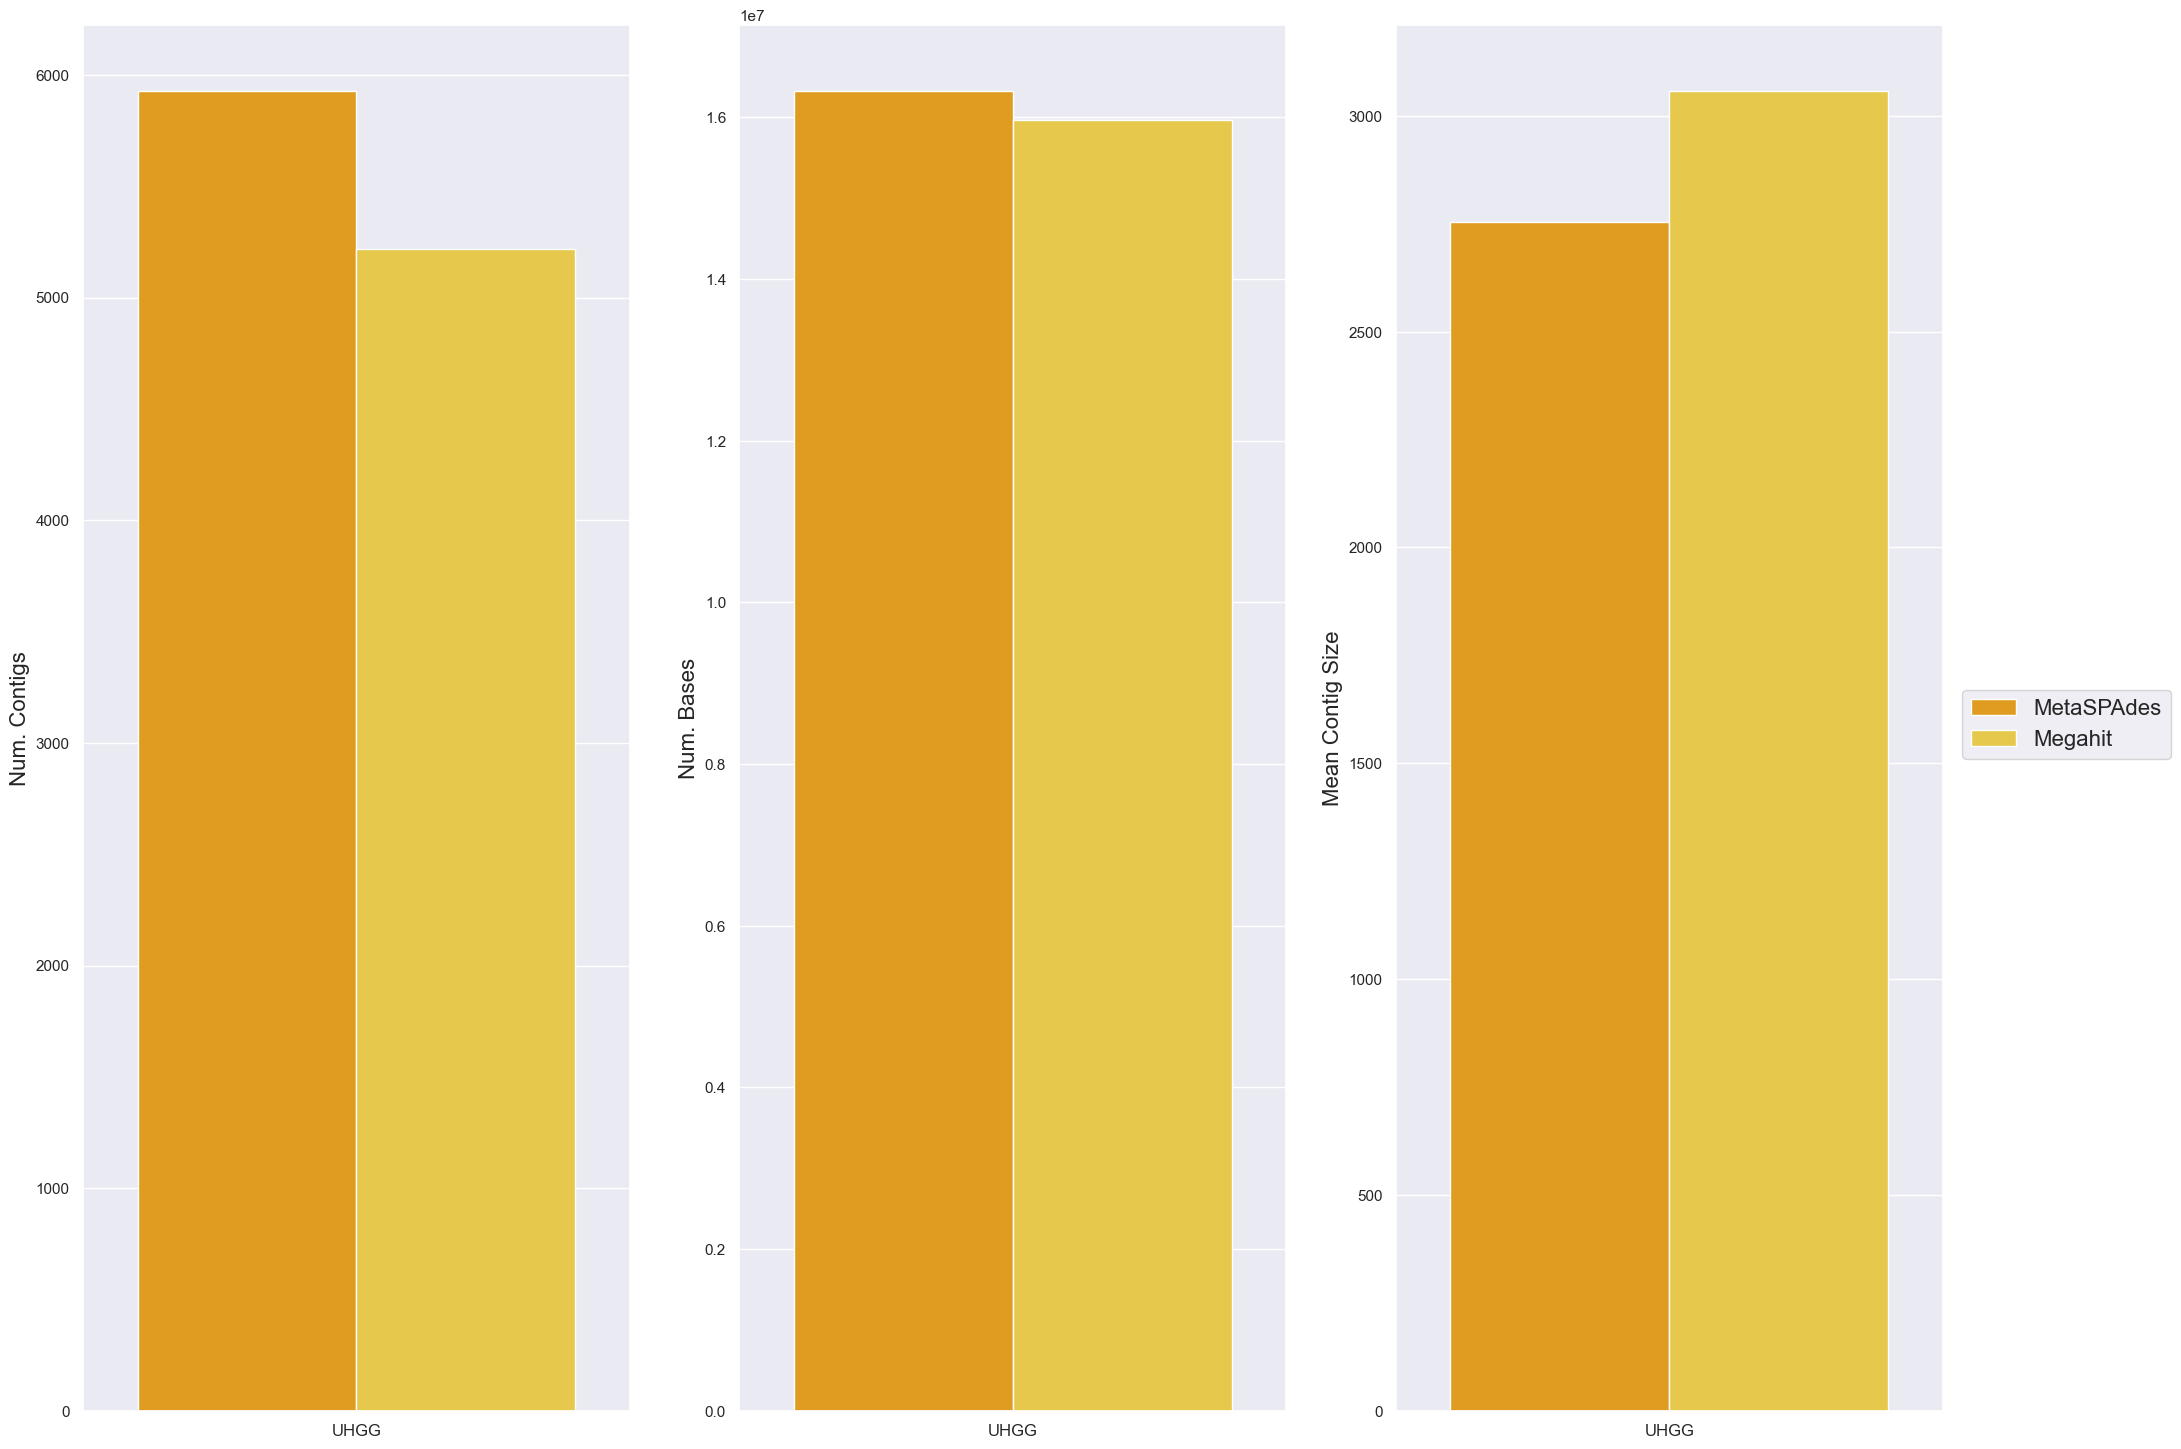

In [11]:
# If applicable, add a global legend and plot the graph
if len(assembs_labeled) > 1: # If multiple assemblers are used
    for i, r in enumerate(row_labels): 
        a = axs[i,0] if i > 1 else axs[0]
        handles, labels = axs[0].get_legend_handles_labels()
        fig.legend(handles, assembs_labeled, loc = 'center right', fontsize = 16)
fig

In [16]:
# Save a large SVG without padding
fig.savefig(join(out_dir, 'num_ctgs_bases_avgs.svg'), dpi = 1000, bbox_inches = 'tight')

## *De novo* assembled contig length distributions

In [23]:
def violin_plot(df, a, cols):
    p = sns.violinplot(data = df, x = 'sample_name', y = 'ctg_size', hue = 'assembler', \
        palette = cols, ax = a)
    p.set_xticklabels(samples_labeled, size = 12) # Relabel each of the groups
    p.set(xlabel = None)
    p.get_legend().remove()
    return p

In [24]:
%%capture
# To suppress figure output
# Define plotting region
# Rows:    Number of sample sets divided by 2. 
# Columns: 2 for visual sanity.
num_cols = 2 if num_samples > 1 else 1
fig, axs = plt.subplots(ceil(len(samples_ordered)/num_cols), num_cols, sharey = 'row', figsize = (12,24)) # in.

In [25]:
# Make each of the panels and then label the leftmost panel in each row
for i, r in enumerate(row_labels):
    df = lengths_df[lengths_df['sample_name'] == r]
    row = i // num_cols
    col = i % num_cols
    if num_samples == 1:
        a = axs
    elif num_samples == 2:
        a = axs[col]
    else:
        a = axs[row,col]
    violin_plot(df, a, sample_asm_colours[i])
    if num_samples == 1:
        axs.set_ylabel('Contig Size (bp)', size = 16)       
    elif num_samples == 2:
        axs[0].set_ylabel('Contig Size (bp)', size = 16)      
    else:
        axs[row,0].set_ylabel('Contig Size (bp)', size = 16)

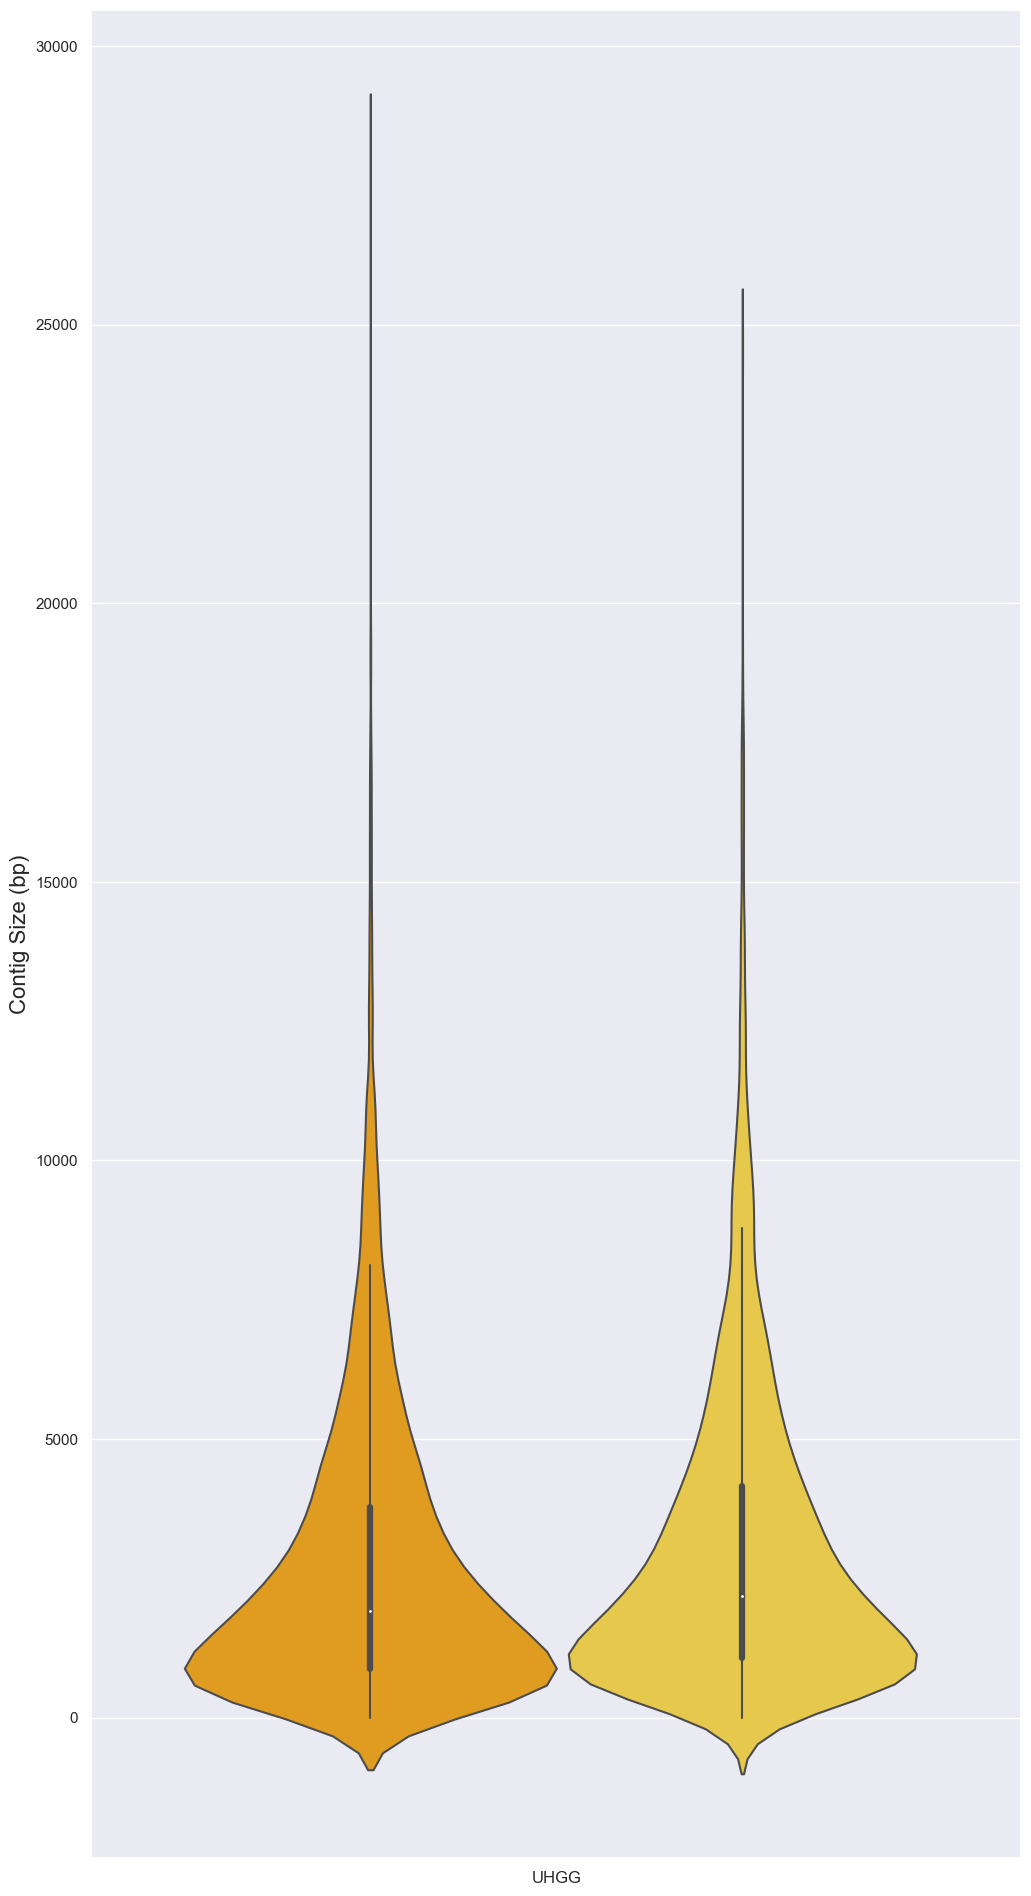

In [26]:
fig

In [27]:
# Save a large SVG without padding
fig.savefig(join(out_dir, 'hist_ctgs_samples.svg'), dpi = 1000, bbox_inches = 'tight')